In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime, os

In [2]:
poses = pd.read_csv('data_odometry_gray/dataset/poses/01.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (1101, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043683e-12,2.326809e-11,1.110223e-16,9.043683e-12,1.000000,2.392370e-10,2.220446e-16,2.326810e-11,2.392370e-10,1.000000,-2.220446e-16
1,0.999050,-1.649780e-03,4.355194e-02,5.154656e-02,1.760423e-03,0.999995,-2.502237e-03,-2.424883e-02,-4.354760e-02,2.576529e-03,0.999048,1.000725e+00
2,0.996050,-5.367949e-03,8.863831e-02,1.464632e-01,6.010224e-03,0.999958,-6.980718e-03,-5.051622e-02,-8.859707e-02,7.485875e-03,0.996039,1.995659e+00
3,0.990927,-5.886878e-03,1.342721e-01,2.879204e-01,7.448178e-03,0.999910,-1.112852e-02,-7.903059e-02,-1.341946e-01,1.202763e-02,0.990882,2.986691e+00
4,0.983622,-3.565066e-03,1.802072e-01,4.657503e-01,6.172884e-03,0.999884,-1.391250e-02,-1.102928e-01,-1.801368e-01,1.479704e-02,0.983530,3.963845e+00


In [3]:
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

In [4]:
#### X_world = R | t * X_camera
####  Z-axis is pointing forward, X-axis is pointing right, and Y-axis is pointing down
####  The camera is looking in the direction of the positive Z-axis
#### 


In [5]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3,4))

In [6]:
gt[1].dot(np.array([0,0,0,1]))

array([ 0.05154656, -0.02424883,  1.000725  ])

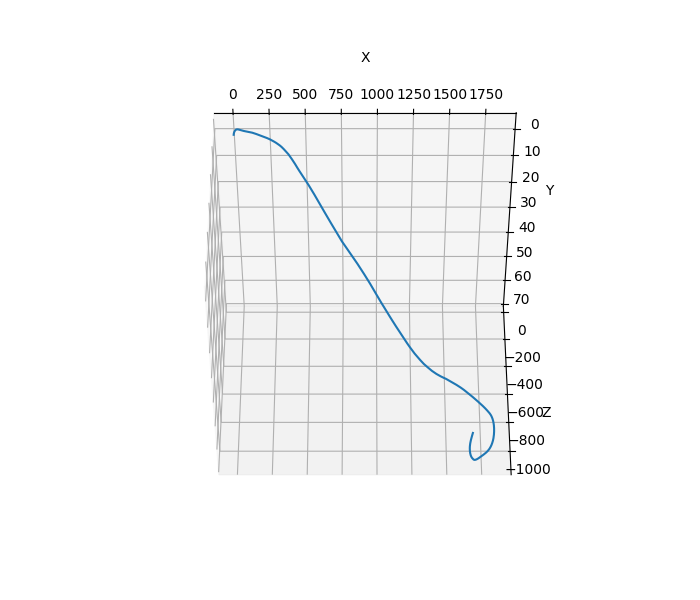

In [7]:
%matplotlib widget
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:,:, 3][:,0], gt[:,:, 3][:,1], gt[:,:, 3][:,2], label='Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=-40, azim=270)

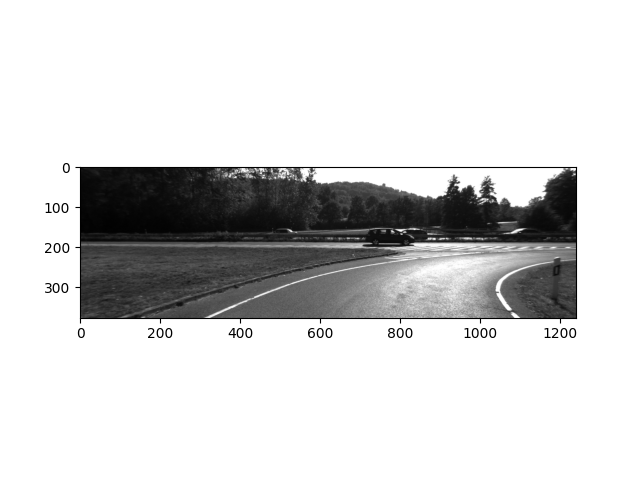

In [8]:
test_img = cv2.imread('data_odometry_gray/dataset/sequences/01/image_0/000000.png', cv2.IMREAD_GRAYSCALE)
type(test_img)
plt.figure()
plt.imshow(test_img, cmap='gray')

In [9]:
len(poses), len(os.listdir('data_odometry_gray/dataset/sequences/01/image_0'))

(1101, 1101)

In [10]:
times = pd.read_csv('data_odometry_gray/dataset/sequences/01/times.txt', header=None)
times.head()

,0
0,0.000000
1,0.103760
2,0.207590
3,0.311605
4,0.415086


In [11]:
calib = pd.read_csv('data_odometry_gray/dataset/sequences/01/calib.txt', header=None, delimiter=' ', index_col=0) 
calib.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [12]:
P0 = np. array(calib.iloc[0]).reshape((3,4))
P0 ## Intrinsic matrix of the camera

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [13]:
#### Intrinsic info of the camera's focal length and optical center, also transformation info 
#### Projection matrix takes 3D coordingates in global frame and projects them into the image plane using
#### Lambda is the scaling factor, also the depth to the point along the Z-axis
####  [u,v,1] = 1/lambda * P * [X,Y,Z,1]

#### Projection matrix is a dot product of intrinsic matrix and extrinsic matrix of the camera
#### k -> intrinsic matrix -> focal length, optical center
#### R -> rotation matrix, t -> translation vector -> extrinsic matrix -> pose of the camera
#### P = K * [R | t]

#### [u,v,1] = 1/Z * K * [R | t] * [X,Y,Z,1]

In [14]:
P1 = np.array(calib.iloc[1]).reshape((3,4))
k1, r1, t1 = cv2.decomposeProjectionMatrix(P1)[:3]
t1 = t1/t1[3]
k1.round(4), r1.round(4), t1.round(4)

(array([[718.856 ,   0.    , 607.1928],
        [  0.    , 718.856 , 185.2157],
        [  0.    ,   0.    ,   1.    ]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[ 0.5372],
        [ 0.    ],
        [-0.    ],
        [ 1.    ]]))

In [15]:
Rt = np.hstack([r1, t1[:3]])
origin = np.array([0,0,0,1])
Rt.dot(origin).round(4).reshape(-1, 1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [16]:
# X value is +0.54, pointing right of the camera frame, so the projection matrix is NOT referring
# to right camnera, but the left camera and treating origin of right camera as the global origin.
# Beacuse it is a rectified projection matrix of a stereo pair, which is intended to project points
# from coordinate frames of multiple cameras into the SAME image plane.

# calibration matrixes are all in REFERENCE OF The lefft cameras image plane.


In [17]:
#### [u_l v_l 1_l] * K_l * [e11 e12 e13
####                        e21 e22 e23
####                        e31 e32 e33] * K_r [ u_r v_r 1_r] = 0 

In [18]:
dataset_path = 'data_odometry_gray/dataset/sequences/01/'

# Load camera calibration
calib_file = os.path.join(dataset_path, 'calib.txt')
calib = np.loadtxt(calib_file, delimiter=' ', dtype=str)
K = np.array(calib[0][1:], dtype=np.float32).reshape(3, 4)[:, :3]  # Intrinsic matrix

# Load ground-truth poses
poses_file = 'data_odometry_gray/dataset/poses/01.txt'
poses = np.loadtxt(poses_file).reshape(-1, 3, 4)

# Load stereo images
left_images = sorted(os.listdir(os.path.join(dataset_path, 'image_0')))
right_images = sorted(os.listdir(os.path.join(dataset_path, 'image_1')))


In [19]:
# ================================
# Feature Extraction & Matching
# ================================
def feature_matching(img1, img2):
    orb = cv2.ORB_create(3000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

    return pts1, pts2, matches

In [20]:
# ================================
# Estimate Motion using Essential Matrix
# ================================
def estimate_motion(pts1, pts2, K):
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    return R, t

# ================================
# Stereo Depth Estimation
# ================================
def compute_depth(imgL, imgR, baseline=0.54, focal_length=718.856):
    stereo = cv2.StereoBM_create(numDisparities=96, blockSize=15)
    disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    depth = (focal_length * baseline) / (disparity + 1e-6)
    return depth

In [21]:
# ================================
# Main VO Loop
# ================================
trajectory = []
pose = np.eye(4)  # Initial pose

for i in range(1, len(left_images)):
    # Load images
    img1 = cv2.imread(os.path.join(dataset_path, 'image_0', left_images[i-1]), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(dataset_path, 'image_0', left_images[i]), cv2.IMREAD_GRAYSCALE)
    
    # Feature matching & motion estimation
    pts1, pts2, matches = feature_matching(img1, img2)
    R, t = estimate_motion(pts1, pts2, K)

    # Compute new pose
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.flatten()
    pose = pose @ T
    trajectory.append(pose[:3, 3])

trajectory = np.array(trajectory)


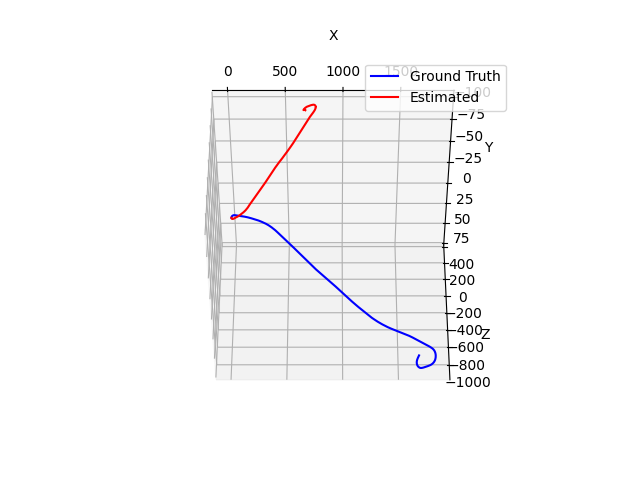

In [25]:
# ================================
# Visualize Trajectory
# ================================
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(poses[:, 0, 3], poses[:, 1, 3], poses[:, 2, 3], label='Ground Truth', color='blue')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Estimated', color='red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.view_init(elev=-40, azim=270)
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ================================
# Load KITTI Dataset
# ================================
dataset_path = 'data_odometry_gray/dataset/sequences/01/'

# Load camera calibration
calib_file = os.path.join(dataset_path, 'calib.txt')
calib = np.loadtxt(calib_file, delimiter=' ', dtype=str)
K = np.array(calib[0][1:], dtype=np.float32).reshape(3, 4)[:, :3]  # Intrinsic matrix

# Load ground-truth poses
poses_file = 'data_odometry_gray/dataset/poses/01.txt'
poses = np.loadtxt(poses_file).reshape(-1, 3, 4)

# Load stereo images
left_images = sorted(os.listdir(os.path.join(dataset_path, 'image_0')))
right_images = sorted(os.listdir(os.path.join(dataset_path, 'image_1')))

# ================================
# Feature Extraction & Matching
# ================================
def feature_matching(img1, img2):
    orb = cv2.ORB_create(3000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

    return pts1, pts2, matches

# ================================
# Estimate Motion using Essential Matrix
# ================================
def estimate_motion(pts1, pts2, K):
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    return R, t

# ================================
# Main VO Loop with Fixes
# ================================
trajectory = []
pose = np.eye(4)  # Initial pose

for i in range(1, len(left_images)):
    # Load images
    img1 = cv2.imread(os.path.join(dataset_path, 'image_0', left_images[i-1]), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(dataset_path, 'image_0', left_images[i]), cv2.IMREAD_GRAYSCALE)
    
    # Feature matching & motion estimation
    pts1, pts2, matches = feature_matching(img1, img2)
    R, t = estimate_motion(pts1, pts2, K)

    # Compute new pose (align with KITTI's coordinate system)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.flatten()
    pose = pose @ T  # Update pose
    trajectory.append(pose[:3, 3])

trajectory = np.array(trajectory)

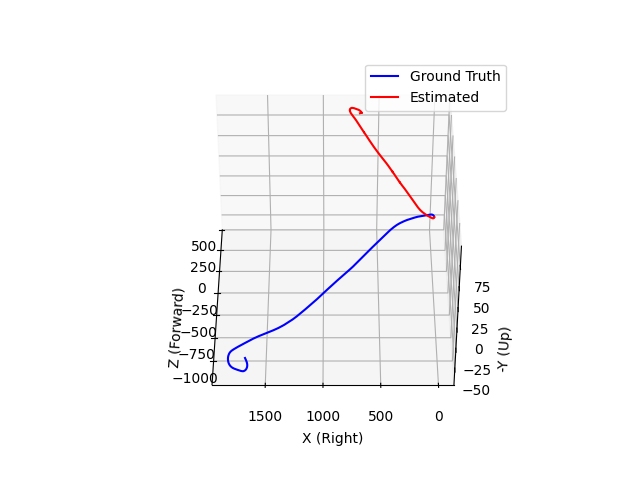

In [32]:
# ================================
# Visualize Trajectory with Fixed Axis
# ================================
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Align axes (KITTI frame): Z forward, X right, Y down
gt_x, gt_y, gt_z = poses[:, 0, 3], poses[:, 1, 3], poses[:, 2, 3]
est_x, est_y, est_z = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]

ax.plot(gt_z, gt_x, -gt_y, label='Ground Truth', color='blue')  # Flip Y for proper orientation
ax.plot(est_z, est_x, -est_y, label='Estimated', color='red')

ax.set_xlabel('Z (Forward)')
ax.set_ylabel('X (Right)')
ax.set_zlabel('-Y (Up)')
ax.legend()
ax.view_init(elev=40, azim=180)

plt.show()
